# Node representation learning with GraphSAGE and UnsupervisedSampler


Stellargraph Unsupervised GraphSAGE is the implementation of GraphSAGE method outlined in the paper: [Inductive Representation Learning on Large Graphs.](http://snap.stanford.edu/graphsage/) W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216
[cs.SI], 2017. 

This notebook is a short demo of how Stellargraph Unsupervised GraphSAGE can be used to learn embeddings of the nodes representing papers in the [CORA citation network](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). Furthermore, this notebook demonstrates the use of the learnt embeddings in a downstream node classification task (classifying papers by subject). Note that the node embeddings can also be used in other graph machine learning tasks, such as link prediction, community detection, etc.

## Unsupervised GraphSAGE:

A high-level explanation of the unsupervised GraphSAGE method of graph representation learning is as follows.

Objective: *Given a graph, learn embeddings of the nodes using only the graph structure and the node features, without using any known node class labels* (hence "unsupervised"; for semi-supervised learning of node embeddings, see this [demo](../node-classification/graphsage-node-classification.ipynb))

**Unsupervised GraphSAGE model:** In the Unsupervised GraphSAGE model, node embeddings are learnt by solving a simple classification task: given a large set of "positive" `(target, context)` node pairs generated from random walks performed on the graph (i.e., node pairs that co-occur within a certain context window in random walks), and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes and their neighbors to node embeddings in a high-dimensional vector space, which preserves structural and feature similarities of the nodes. Unlike embeddings obtained by algorithms such as [Node2Vec](https://snap.stanford.edu/node2vec), this mapping is inductive: given a new node (with attributes) and its links to other nodes in the graph (which was unseen during model training), we can evaluate its embeddings without having to re-train the model. 

In our implementation of Unsupervised GraphSAGE, the training set of node pairs is composed of an equal number of positive and negative `(target, context)` pairs from the graph. The positive `(target, context)` pairs are the node pairs co-occurring on random walks over the graph whereas the negative node pairs are sampled randomly from a global node degree distribution of the graph.

The architecture of the node pair classifier is the following. Input node pairs (with node features) are fed, together with the graph structure, into a pair of identical GraphSAGE encoders, producing a pair of node embeddings. These embeddings are then fed into a node pair classification layer, which applies a binary operator to those node embeddings (e.g., concatenating them), and passes the resulting node pair embeddings through a linear transform followed by a binary activation (e.g., sigmoid), thus predicting a binary label for the node pair. 

The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted node pair labels and true link labels) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links generated on demand and fed into the model.

Node embeddings obtained from the encoder part of the trained classifier can be used in various downstream tasks. In this demo, we show how these can be used for predicting node labels.

In [22]:
# install StellarGraph if running on Google Colab
# import sys
# if 'google.colab' in sys.modules:
#   %pip install -q stellargraph[demos]==1.2.1

In [23]:
# verify that we're using the correct version of StellarGraph for this notebook
# import stellargraph as sg

# try:
#     sg.utils.validate_notebook_version("1.2.1")
# except AttributeError:
#     raise ValueError(
#         f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
#     ) from None

In [24]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
import math

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

## Loading the CORA network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [25]:
f = open("data/mouse.interaction") ## Human Data: change file name, if you want to run human data
lines = f.readlines() 
f.close()

list_a=[]
list_b=[]
nodes = []

for i in range(len(lines)):
    tokens = lines[i].split("\t")
    list_a.append(tokens[0])
    list_b.append(tokens[1].strip("\n"))
    if (tokens[0] not in nodes):
        nodes.append(tokens[0])
    if (tokens[1].strip("\n") not in nodes):
        nodes.append(tokens[1].strip("\n"))
    
print (len(list_a),len(list_b), len(nodes))

square_numeric_edges = pd.DataFrame(
    {"source": list_a, "target": list_b}
)
square_numeric_edges

1229 1229 744


,source,target
0,A2AQR4,A2AQR4
1,A2AQR4,Q6PGF3
2,A2AQR4,Q99PM3
3,B2RWS6,Q04207
4,B2RWS6,Q9JHD1
...,...,...
1224,Q9Z0H0,Q9Z1N2
1225,Q9Z1A1,Q9Z1A1
1226,Q9Z1N2,Q9Z1X9
1227,Q9Z223,Q9Z223


In [26]:
ind = np.arange(0,len(nodes),1)

# RANDOM DATA (if you want to get embeddings purely from network structure, use random data instead of exp. data)

# f1=[]
# f2=[]
# for i in range(len(nodes)):
#     f1.append(np.random.random(1)[0])
#     f2.append(np.random.random(1)[0])

# print (len(f1))
# print (len(ind))


In [27]:

# EXPRESSION DATA (NOTE: un-comment mouse section / human section)

# 1- Mouse
a = np.zeros((len(nodes),67))
mouse_exp_data = pd.read_csv("data/mouse_exp_data.csv")  ## change file name
print (mouse_exp_data.shape)

# 2- Human
# a = np.zeros((len(nodes),158))
# mouse_exp_data = pd.read_csv("data/human_exp_data_avg.csv", header = None)  ## change file name
# print (mouse_exp_data.shape)

mouse_exp_data = np.asarray(mouse_exp_data)
exp_genes = mouse_exp_data[:,1]
print (len(exp_genes))
for i in range(len(exp_genes)):
    index = nodes.index(exp_genes[i])
    for j in range(a.shape[1]):
        a[index][j] = mouse_exp_data[i][j+2]
        
print (a.shape)


# ***** IMPORTANT COMMENTS, PLEASE READ IT CAREFULLY ******

### uncomment the below section if you want to run normalized and discritized version.
### Otherwise, by default it will use log based normalization that achieved best results.
### If you want simple normalization then un-comment the below line and comment rest of the code of this cell.

# OPTION: 1
# normalized = preprocessing.normalize(a) # Normalization

# OPTION: 2
# norm_012 = np.zeros((normalized.shape[0], normalized.shape[1]))
# for i in range(normalized.shape[0]):
#     for j in range(normalized.shape[1]):
#         if normalized[i][j] <= 0.10:
#             norm_012[i][j] = 0
#         elif normalized[i][j] > 0.10 and normalized[i][j] <= 0.25:
#             norm_012[i][j] = 1
#         elif normalized[i][j] > 0.25 and normalized[i][j] <= 0.50:
#             norm_012[i][j] = 2
#         elif normalized[i][j] > 0.50 and normalized[i][j] <= 0.75:
#             norm_012[i][j] = 3
#         else:
#             norm_012[i][j] = 4

# OPTION: 3
# log normalization
norm_log = np.zeros((a.shape[0], a.shape[1]))
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        if a[i][j] > 0:
            norm_log[i][j] = round(math.log2(a[i][j]),2)

(700, 69)
700
(744, 67)


In [28]:
# Random / Expressions Data Integration ##
square_node_data = pd.DataFrame(norm_log, index=nodes) #  un-comment this for log based normalization data
# square_node_data = pd.DataFrame(normalized, index=nodes) # un-comment this for normalized data
# square_node_data = pd.DataFrame(norm_012, index=nodes) # un-comment this for normalized + discritized data
# square_node_data = pd.DataFrame({"x1": f1, "x2": f2}, index=nodes) # un-comment this for random data

square_node_data

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
A2AQR4,2.29,2.25,2.12,2.75,2.46,2.40,2.56,2.05,1.96,2.23,...,2.42,0.61,-0.10,3.40,3.44,3.24,3.27,2.26,2.15,1.69
Q6PGF3,3.43,3.56,2.89,3.01,3.57,3.78,3.61,3.98,4.14,3.84,...,2.64,5.78,6.02,3.62,3.72,3.52,3.34,3.38,3.67,2.31
Q99PM3,3.16,3.24,3.28,2.93,3.19,3.29,3.05,3.06,3.29,3.23,...,2.86,3.94,3.95,3.69,3.78,3.88,3.61,4.23,4.07,1.94
B2RWS6,3.38,3.41,3.24,3.42,3.27,3.48,3.19,3.41,3.40,3.15,...,2.35,3.85,3.72,4.33,4.44,4.30,4.40,3.54,3.78,1.28
Q04207,4.23,4.43,4.15,4.35,2.83,2.71,2.60,2.72,2.85,2.70,...,3.27,4.03,4.14,4.54,4.40,4.54,4.44,4.43,4.53,3.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9JLV1,5.22,5.32,4.62,5.21,1.15,0.93,0.78,0.76,1.08,0.84,...,4.13,3.58,3.32,1.12,1.12,1.21,0.96,4.04,4.13,3.49
Q9QZ09,3.23,3.43,3.52,3.36,4.04,4.19,4.16,3.92,4.14,3.92,...,2.09,5.63,5.65,4.94,4.81,4.82,4.99,3.53,4.34,1.15
Q9WU42,5.25,5.30,5.66,5.60,5.00,5.29,4.82,5.08,4.88,4.92,...,3.10,3.75,4.10,3.89,3.91,3.80,3.95,4.21,4.83,2.88
Q9Z2V6,4.54,4.60,4.60,4.56,5.78,6.04,5.96,5.78,5.74,5.83,...,3.74,4.30,4.31,4.27,3.85,4.07,4.32,4.51,5.00,4.28


In [29]:
from stellargraph import StellarGraph
G = StellarGraph(square_node_data, square_numeric_edges)

In [30]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 744, Edges: 1229

 Node types:
  default: [744]
    Features: float32 vector, length 67
    Edge types: default-default->default

 Edge types:
    default-default->default: [1229]
        Weights: all 1 (default)
        Features: none


## Unsupervised GraphSAGE  with on demand sampling
The Unsupervised GraphSAGE requires a training sample that can be either provided as a list of `(target, context)` node pairs or it can be provided with an `UnsupervisedSampler` instance that takes care of generating positive and negative samples of node pairs on demand. In this demo we discuss the latter technique. 

### UnsupervisedSampler:
The `UnsupervisedSampler` class takes in a `Stellargraph` graph instance. The `generator` method in the `UnsupervisedSampler`  is responsible for generating equal number of positive and negative node pair samples from the graph  for training. The samples are generated by performing uniform random walks over the graph, using `UniformRandomWalk` object. Positive `(target, context)` node pairs are extracted from the walks, and for each 
positive pair a corresponding negative pair `(target, node)` is generated by randomly sampling `node` from the degree distribution of the graph. Once the `batch_size` number of samples is accumulated, the generator yields a list of positive and negative node pairs along with their respective 1/0 labels.  

In the current implementation, we use uniform random walks to explore the graph structure. The length and number of walks, as well as the root nodes for starting the walks can be user-specified. The default list for root nodes is all nodes of the graph, default `number_of_walks` is 1 (at least one walk per root node), and the default `length` of walks is 2 (need at least one node beyond the root node on the walk as a potential positive context).

**1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.**

In [31]:
nodes = list(G.nodes())
number_of_walks = 1
length = 2

**2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.**

In [32]:
unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)

The graph G together with the unsupervised sampler will be used to generate samples.

**3. Create a node pair generator:**

Next, create the node pair generator for sampling and streaming the training data to the model. The node pair generator essentially "maps" pairs of nodes `(target, context)` to the input of GraphSAGE: it either takes minibatches of node pairs, or an `UnsupervisedSampler` instance which generates the minibatches of node pairs on demand. The generator samples 2-hop subgraphs with `(target, context)` head nodes extracted from those pairs, and feeds them, together with the corresponding binary labels indicating which pair represent positive or negative sample, to the input layer of the node pair classifier with GraphSAGE node encoder, for SGD updates of the model parameters.

Specify:
1. The minibatch size (number of node pairs per minibatch).
2. The number of epochs for training the model.
3. The sizes of 1- and 2-hop neighbor samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE encoder. In this example, we are defining a 2-layer GraphSAGE encoder.

In [33]:
batch_size = 128
epochs = 20 # change number of epochs (hyper-parameter)
num_samples = [10, 5]

In the following we show the working of node pair generator with the UnsupervisedSampler, which will generate samples on demand.

In [34]:
generator = GraphSAGELinkGenerator(G, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

Build the model: a 2-layer GraphSAGE encoder acting as node representation learner, with a link classification layer on concatenated (`citing-paper`, `cited-paper`) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1).
Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the GraphSAGE encoder.

In [35]:
layer_sizes = [32,32] # dimension size
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.1, normalize="l2", 
    aggregator=sg.layer.MaxPoolingAggregator, activations=["relu","softmax"]
)
# here, we have multiple hyper-parameters, change the values if you want to further explore this model

In [36]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

Final node pair classification layer that takes a pair of nodes' embeddings produced by `graphsage` encoder, applies a binary operator to them to produce the corresponding node pair embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [37]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE encoder and prediction layer into a Keras model, and specify the loss

In [38]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.binary_crossentropy,
    #loss = keras.losses.mean_squared_error,
    #loss = keras.losses.hinge,
    metrics=[keras.metrics.binary_accuracy],
)

**4. Train the model.**

In [39]:
history = model.fit(
    train_gen,
    epochs=20,
    verbose=1,
    use_multiprocessing=False,
    workers=8,
    shuffle=True,
)

Epoch 1/20
12/12 [==============================] - 4s 17ms/step - loss: 1.3468 - binary_accuracy: 0.5585
Epoch 2/20
12/12 [==============================] - 1s 45ms/step - loss: 1.0294 - binary_accuracy: 0.5927
Epoch 3/20
12/12 [==============================] - 1s 55ms/step - loss: 0.7766 - binary_accuracy: 0.6512
Epoch 4/20
12/12 [==============================] - 1s 41ms/step - loss: 0.7052 - binary_accuracy: 0.6546
Epoch 5/20
12/12 [==============================] - 1s 46ms/step - loss: 0.6442 - binary_accuracy: 0.6801
Epoch 6/20
12/12 [==============================] - 1s 40ms/step - loss: 0.6594 - binary_accuracy: 0.6707
Epoch 7/20
12/12 [==============================] - 1s 43ms/step - loss: 0.6094 - binary_accuracy: 0.7016
Epoch 8/20
12/12 [==============================] - 1s 43ms/step - loss: 0.6257 - binary_accuracy: 0.6942
Epoch 9/20
12/12 [==============================] - 1s 41ms/step - loss: 0.5971 - binary_accuracy: 0.6983
Epoch 10/20
12/12 [===========================

Note that multiprocessing is switched off, since with a large training set of node pairs, multiprocessing can considerably slow down the training process with the data being transferred between various processes. 

Also, multiple workers can be used with `Keras version 2.2.4` and above, and it speeds up the training process considerably due to multi-threading.

## Extracting node embeddings
Now that the node pair classifier is trained, we can use its node encoder part as node embeddings evaluator. Below we evaluate node embeddings as activations of the output of GraphSAGE layer stack, and visualise them, coloring nodes by their subject label.

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Building a new node-based model**

The `(src, dst)` node pair classifier `model` has two identical node encoders: one for source nodes in the node pairs, the other for destination nodes in the node pairs passed to the model. We can use either of the two identical encoders to evaluate node embeddings. Below we create an embedding model by defining a new Keras model with `x_inp_src` (a list of odd elements in `x_inp`) and `x_out_src` (the 1st element in `x_out`) as input and output, respectively. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [41]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

We also need a node generator to feed graph nodes to `embedding_model`. We want to evaluate node embeddings for all nodes in the graph:

In [42]:
node_ids = nodes#node_subjects.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

We now use `node_gen` to feed all nodes into the embedding model and extract their embeddings:

In [43]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

6/6 [==============================] - 1s 39ms/step


In [44]:
print ((node_embeddings.shape))

(744, 32)


In [45]:
# f = open("mouse_emd.csv")
mouse_nodes = np.array(nodes).reshape(len(nodes),1)
mouse_ind = np.array(ind).reshape(len(nodes),1)

print (mouse_nodes.shape, mouse_ind.shape)

np.savetxt("network_embeddings/mouse_explog_20.csv", node_embeddings, delimiter=",") ## change file name
new = np.concatenate((mouse_ind, mouse_nodes), axis=1)
print (new.shape)
np.savetxt("network_embeddings/mouse_explog_20_nodes.csv", new, delimiter=",",fmt='%s') ## change file name

(744, 1) (744, 1)
(744, 2)


### Visualize the node embeddings 
Next we visualize the node embeddings in 2D using t-SNE. Colors of the nodes depict their true classes (subject in the case of Cora dataset) of the nodes. 

In [46]:
#node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=nodes)
    emb_transformed["label"] = ind#node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = "Y"#node_subject

/home/umair/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/umair/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


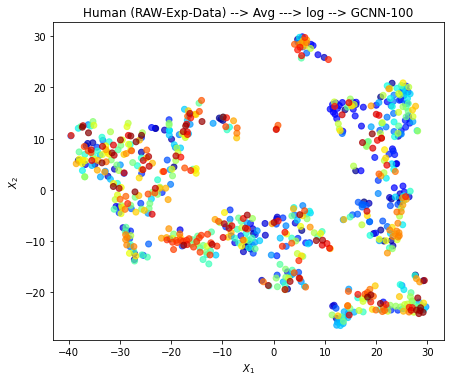

In [47]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("Human (RAW-Exp-Data) --> Avg ---> log --> GCNN-100")
plt.show()

The observation that same-colored nodes in the embedding space are concentrated together is indicative  of similarity of embeddings of papers on the same topics. We would emphasize here again that the node embeddings are learnt in unsupervised way, without using true class labels. 